In [1]:
# import distributed.protocol.torch  # noqa
# from distributed.protocol.serialize import serialize, deserialize, dask_serialize
# import torch

# @dask_serialize.register(torch.Tensor)
# def serialize_torch_Tensor(t):
#     """Need to fix this implementation when gpu is on device

#     This is a bug in dask

#     copied from here: https://github.com/dask/distributed/blob/172f23d78ac1f8c6117b9edfd0019ec94cd7d39d/distributed/protocol/torch.py#L15
#     """  # noqa
#     requires_grad_ = t.requires_grad

#     if requires_grad_:
#         sub_header, frames = serialize(t.detach().cpu().numpy())
#     else:
#         sub_header, frames = serialize(t.cpu().numpy())

#     header = {"sub-header": sub_header}
#     if t.grad is not None:
#         grad_header, grad_frames = serialize(t.grad.numpy())
#         header["grad"] = {"header": grad_header, "start": len(frames)}
#         frames += grad_frames
#     header["requires_grad"] = requires_grad_
#     header["device"] = t.device.type
#     return header, frames

In [2]:
import openslide
from openslide import lowlevel as openslide_ll
from ctypes import c_uint32, POINTER, cast, addressof, c_void_p, byref, c_uint8, sizeof, c_uint16
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Optional
from loguru import logger
import re
import cv2
from multiprocessing import RawArray
import concurrent
from concurrent.futures import ProcessPoolExecutor
from concurrent import futures
from tqdm import tqdm
from pathlib import Path
import dask.array as da
import dask
from dask.distributed import progress, wait
import torch
from dask.distributed import Client, LocalCluster

import shiprec
from shiprec.slide import load_slide
from shiprec.progress import tqdm_dask
import time

starttime = time.time()

SLIDE_FILE = "/data/data/TCGA-BRCA-DX-IMGS_1133/TCGA-AO-A12B-01Z-00-DX1.B215230B-5FF7-4B0A-9C1E-5F1658534B11.svs"
TARGET_PATCH_FILE = "/app/normalization_template.jpg"

In [3]:
from shiprec.cluster import MixedCluster

cluster = MixedCluster(n_cpu_workers=5, gpu_devices=[2,3,4], memory_limit="32GB")
# client = Client(n_workers=8, threads_per_worker=1, memory_limit="32GB")
client = Client(cluster.scheduler_address)
gpu_workers = [(w.host, w.port) for w in cluster.workers.values() if w.resources is not None and w.resources.get("GPU", 0) > 0]
client

<Client: 'tcp://127.0.0.1:35389' processes=8 threads=8, memory=238.42 GiB>

In [4]:
target = cv2.cvtColor(cv2.imread(str(TARGET_PATCH_FILE)), cv2.COLOR_BGR2RGB)
target_np = target
target = da.from_array(target)
target

dask.array<array, shape=(512, 512, 3), dtype=uint8, chunksize=(512, 512, 3), chunktype=numpy.ndarray>

In [5]:
slide = load_slide(SLIDE_FILE, target_mpp=256./224.)
# slide = client.persist(slide)
slide

2023-08-08 16:29:33.311 | INFO     | shiprec.read.mpp:get_slide_mpp:42 - MPP successfully extracted using extract_mpp_from_properties: 0.499
2023-08-08 16:29:33.312 | DEBUG    | shiprec.read:load_slide:21 - Slide has 3 levels with following downsamples: {0: 1.0, 1: 4.000140674347211, 2: 16.004303859372538}
2023-08-08 16:29:33.312 | INFO     | shiprec.read:load_slide:30 - Using level 0 with level_mpp=0.499 for slide_mpp=0.499 and target_mpp=1.143


dask.array<resize_chunk, shape=(22400, 31360, 3), dtype=uint8, chunksize=(4480, 4480, 3), chunktype=numpy.ndarray>

In [6]:
from shiprec.patching import split_slide_into_patches, flatten_patches_and_coords
from shiprec.canny import get_canny_foreground_mask

patches, patch_coords = split_slide_into_patches(slide, patch_size=224)
patches, patch_coords = flatten_patches_and_coords(patches, patch_coords)

# Filter out background patches
patch_mask = get_canny_foreground_mask(patches)
patches = patches[patch_mask]
patch_coords = patch_coords[patch_mask]
patches

dask.array<getitem_variadic, shape=(nan, 224, 224, 3), dtype=uint8, chunksize=(nan, 224, 224, 3), chunktype=numpy.ndarray>

In [7]:
(patches, patch_coords) = client.persist((patches, patch_coords))
tqdm_dask(patches)
patches

  0%|          | 0/45 [00:00<?, ?it/s]

dask.array<getitem_variadic, shape=(nan, 224, 224, 3), dtype=uint8, chunksize=(nan, 224, 224, 3), chunktype=numpy.ndarray>

In [8]:
patches.compute_chunk_sizes()
patches = patches.rechunk((256, 224, 224, 3))
patches

dask.array<rechunk-merge, shape=(5422, 224, 224, 3), dtype=uint8, chunksize=(256, 224, 224, 3), chunktype=numpy.ndarray>

In [9]:
from shiprec.macenko.dask import DaskMacenkoNormalizer
normalizer = DaskMacenkoNormalizer(exact=True)
normalizer.fit(target)
normalized = normalizer.normalize_flattened_image(patches.reshape(-1, 3))
normalized = normalized.reshape(patches.shape)
normalized

dask.array<reshape, shape=(5422, 224, 224, 3), dtype=uint8, chunksize=(256, 224, 224, 3), chunktype=numpy.ndarray>

In [10]:
normalized = normalized.persist()
tqdm_dask(normalized, desc="Performing Macenko normalization")

Performing Macenko normalization:   0%|          | 0/22 [00:00<?, ?it/s]

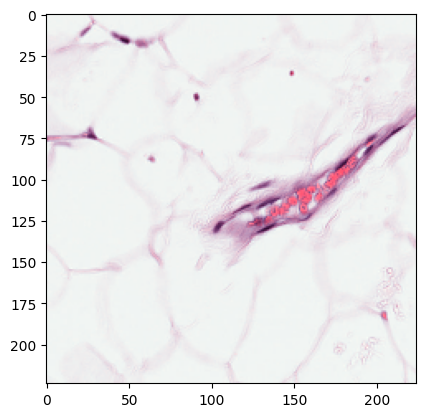

In [11]:
plt.imshow(normalized[50].compute())

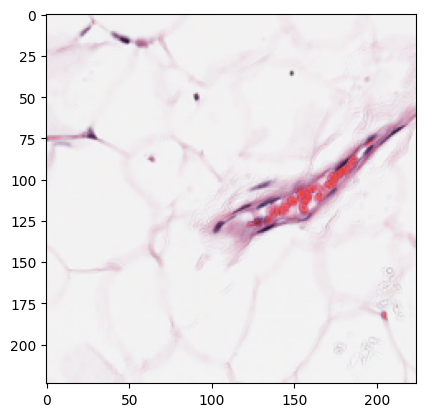

In [12]:
plt.imshow(patches[50].compute())

In [13]:
import hashlib
from shiprec.libs.ctranspath.swin_transformer import swin_tiny_patch4_window7_224, ConvStem
from torch import nn
import torch

checkpoint_path = Path("/app/weights") / "ctranspath.pth"

sha256 = hashlib.sha256()
with open(checkpoint_path, 'rb') as f:
    while True:
        data = f.read(1 << 16)
        if not data:
            break
        sha256.update(data)

assert sha256.hexdigest() == '7c998680060c8743551a412583fac689db43cec07053b72dfec6dcd810113539'

model = swin_tiny_patch4_window7_224(embed_layer=ConvStem, pretrained=False)
model.head = nn.Identity()

ctranspath = torch.load(checkpoint_path, map_location=torch.device("cpu"))
model.load_state_dict(ctranspath['model'], strict=True)

/app/env/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


<All keys matched successfully>

In [14]:
model.eval()

SwinTransformer(
  (patch_embed): ConvStem(
    (proj): Sequential(
      (0): Conv2d(3, 12, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(12, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (4): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(24, 96, kernel_size=(1, 1), stride=(1, 1))
    )
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (layers): Sequential(
    (0): BasicLayer(
      dim=96, input_resolution=(56, 56), depth=2
      (blocks): ModuleList(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=96, out_features=288, bias=True

In [15]:
dmodel = client.scatter(model)
dmodel

<Future: finished, type: shiprec.libs.ctranspath.swin_transformer.SwinTransformer, key: SwinTransformer-2951c751d1f07d179b3f583a9d264c9d>

In [16]:
from torchvision import transforms as T
transform = T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

def predict(batch: np.ndarray, dmodel) -> np.ndarray:
    dmodel.cuda() # will only be slow the first time per worker (because we leave the model on the GPU)
    batch = torch.from_numpy(batch).float() / 255.0
    batch = transform(batch).cuda()
    # batch is of shape (batch_size, 3, 224, 224)
    with torch.no_grad():
        features = dmodel(batch).cpu().numpy()
    dmodel.cpu() # need to do this otherwise we get a serialization error
    return features

tensor_patches = da.moveaxis(patches, -1, 1) # (N, 3, 224, 224)
with dask.annotate(resources={"GPU": 1}):
    features = da.map_blocks(predict, tensor_patches, dmodel, meta=np.zeros((), dtype=float), drop_axis=(1,2,3), new_axis=1, chunks=(tensor_patches.chunks[0], 768))
features = features.persist(optimize_graph=False) # if optimize_graph=True, then the graph optimization might move the model to a non-GPU worker
tqdm_dask(features)

  0%|          | 0/22 [00:00<?, ?it/s]

In [17]:
# def ensure_full_chunks(chunk):
#     if chunk.shape[0] < 256:
#         zeros = np.zeros((256 - chunk.shape[0], *chunk.shape[1:]), dtype=chunk.dtype)
#         chunk = np.concatenate((chunk, zeros), axis=0)
#     return chunk
# x = pred.map_blocks(ensure_full_chunks, chunks=(256, 768), dtype=float)
# x

In [18]:
da.to_zarr(features.rechunk(-1), "features.zarr", overwrite=True)

In [19]:
endtime = time.time()
print(f"Time elapsed: {endtime - starttime:.2f} seconds")

Time elapsed: 133.79 seconds


In [23]:
x = da.to_zarr(features.rechunk(-1), "features.zarr", overwrite=True, compute=False)

In [24]:
x

Delayed('store-da26bbd70eca06617aff135640da82ac')